
Testing models with prefix: username_4
Loaded models: []
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


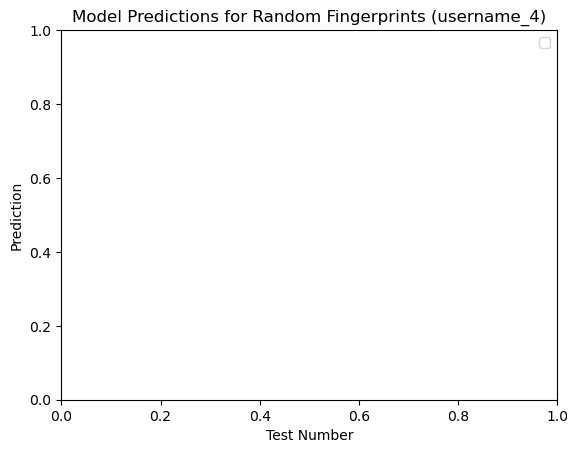


Testing models with prefix: username_2
Loaded models: ['username_2_1.h5', 'username_2_2.h5', 'username_2_3.h5', 'username_2_4.h5', 'username_2_5.h5', 'username_2_6.h5']
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_4


ValueError: in user code:

    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\lion\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 35, 280, 4), found shape=(None, 75, 75, 3)


In [1]:
# Importieren der notwendigen Bibliotheken
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        base64_data = base64_string
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data).convert("RGB")  # Konvertieren zu RGB
    image = image.resize((75, 75))  # Größe anpassen
    return image

# Funktion zum Vorbereiten des Bildes für das Modell
def prepare_image(image, target_size):
    image_resized = image.resize(target_size)  # Bild auf die Zielgröße ändern
    image_array_resized = np.array(image_resized)
    image_array_normalized = image_array_resized / 255.0
    image_array_normalized = np.expand_dims(image_array_normalized, axis=0)
    return image_array_normalized

# Funktion zum Laden der Modelle basierend auf Präfixen
def load_models(model_dir, prefixes):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if any(f.startswith(prefix) for prefix in prefixes)]
    model_names = [os.path.basename(path) for path in model_paths]
    models = []
    for path in model_paths:
        if os.path.exists(path):
            models.append(tf.keras.models.load_model(path, compile=False))
        else:
            print(f"Model file not found: {path}")
    for model in models:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return models, model_names

# Zufälligen Fingerabdruck aus der Datenbank laden
def get_random_fingerprint(username):
    fingerprints = list(collection.aggregate([{"$match": {"username": username}}, {"$sample": {"size": 1}}]))
    if not fingerprints:
        raise ValueError(f"No fingerprints found in the database for username: {username}")
    random_fingerprint = fingerprints[0]
    if 'canvases' not in random_fingerprint or not random_fingerprint['canvases']:
        raise KeyError("The field 'canvases' was not found in the document or is empty")
    base64_image = random.choice(random_fingerprint['canvases'])  # Zufälliges Bild aus dem 'canvases'-Array auswählen
    return decode_base64_image(base64_image)

# Mehrere Fingerabdrücke abrufen und vorbereiten
def get_multiple_fingerprints(usernames, num_tests):
    images = []
    for _ in range(num_tests):
        username = random.choice(usernames)
        print(f"Loading random canvas for username: {username}")
        image = get_random_fingerprint(username)
        images.append((username, image))
    return images

# Präfixe für die Modelle
prefixes = ["username_4", "username_2"]  # Beispiel: kann auch andere Präfixe enthalten

# Anzahl der Tests
num_tests = 10

# Modelle laden und testen
for prefix in prefixes:
    print(f"\nTesting models with prefix: {prefix}")
    models, model_names = load_models('models', [prefix])
    
    # Geladene Modelle anzeigen
    print(f"Loaded models: {model_names}")
    
    # Mehrere Fingerabdrücke abrufen und vorbereiten
    images = get_multiple_fingerprints(prefixes, num_tests)
    prepared_images = [(username, prepare_image(image, target_size=(75, 75))) for username, image in images]
    
    # Ergebnisse speichern
    all_results = {name: [] for name in model_names}
    for username, image_array_normalized in prepared_images:
        for model, name in zip(models, model_names):
            prediction = model.predict(image_array_normalized)
            all_results[name].append((username, prediction[0][0]))
    
    # Ergebnisse in der Konsole ausgeben
    for name in model_names:
        print(f"\nResults for model: {name}")
        for i, (username, result) in enumerate(all_results[name]):
            print(f"Test {i+1}: Username = {username}, Prediction = {result}")
    
    # Ergebnisse grafisch darstellen
    fig, ax = plt.subplots()
    for name in model_names:
        results = [result for username, result in all_results[name]]
        ax.plot(range(num_tests), results, label=name)
    ax.set_xlabel('Test Number')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Predictions for Random Fingerprints ({prefix})')
    ax.legend()
    plt.show()

# Fingerabdrücke anzeigen
fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
for i, (username, image) in enumerate(images):
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(username)
    axes[i].axis('off')
plt.show()